#### Import Libraries

In [1]:
import pandas   as pd

from sklearn.metrics            import f1_score, accuracy_score, roc_auc_score, log_loss, confusion_matrix

from functions.clean_data import clean_df
from functions.Sampled_StratifiedKFold import SSKFold

import warnings
warnings.filterwarnings("ignore")

#### Data Load and Cleaning

In [2]:
# Load the dataset
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')

# Concat the two DataFrames (makes cleaning easier)
df = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

# Clean DataFrame
clean_df(df)

# Get Dummies where applicable
df = pd.get_dummies(df)

# Split into Training and Testing
df_train = df.loc[:890]
df_test  = df.loc[891:].drop(['Survived'], axis=1)

# Set Train X/y Arrays
dfX = df_train.drop(columns=['Survived', 'PassengerId'])
dfy = df_train['Survived']

# Set Train X Array
dfX_test = df_test.drop(columns=['PassengerId'])

# Training Details
tr_rows = dfX.shape[0]
te_rows = dfX_test.shape[0]
n_cols = dfX.shape[1]
classes = pd.unique(dfy)
n_classes = len(classes)

# Summarize Training
print('Train Examples: %d' % tr_rows)
print('Test Examples: %d' % te_rows)
print('Train Inputs:   %d' % n_cols)
print('N Classes:  %d' % n_classes)
print('Classes: %s' % classes)
print('Class Breakdown:')

for c in classes:
	total = len(dfy[dfy == c])
	ratio = (total / float(len(dfy))) * 100
	print(' - Class %s: %d (%.2f%%)' % (str(c), total, ratio))


Train Examples: 891
Test Examples: 418
Train Inputs:   25
N Classes:  2
Classes: [0. 1.]
Class Breakdown:
 - Class 0.0: 549 (61.62%)
 - Class 1.0: 342 (38.38%)


#### K-Fold with OverSampling & UnderSampling

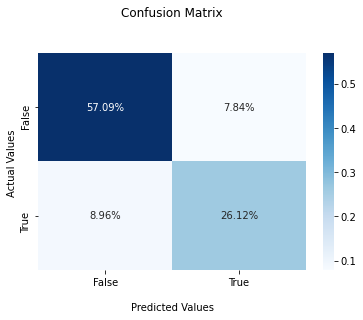

Validation Score:     83.21%
Optimal Threshold:     0.59
Cross Validation Scores: ['77.60%', '79.20%', '76.00%', '72.58%', '80.65%']


In [3]:
best_threshold, best_score, score_list, model_list, proba, probs = SSKFold(dfX, dfy, scoring_criteria = accuracy_score, cf = True, random_seed = 10)

print('Validation Score:     {:.2f}%'.format(best_score*100))
print('Optimal Threshold:     {:.2f}'.format(best_threshold))
print('Cross Validation Scores: {}'.format(list([ '{:.2f}%'.format(elem*100) for elem in score_list ])))

#### Predict X-Test

In [4]:
# Define Empty list of probabilities
y_probs = pd.DataFrame()

# For each model is the model_list, predict probabilities for the hold out
for i in range(0, len(model_list)):
    y_probs[i] = model_list[i].predict_proba(dfX_test)[:, 1]

# Average Probabilities for each record
y_probs['Survived_proba'] = (y_probs * score_list).sum(axis = 1) / sum(score_list)

# Determine if the probability is above or below threshold (turn into binary)
y_probs['Survived'] = (y_probs['Survived_proba'] >= best_threshold).astype('int')

# Add PassengerId to DataFrame
y_probs['PassengerId'] = df_test['PassengerId'].reset_index(drop=True)

# Create CSV of Predictions
df_yhat = y_probs[['PassengerId', 'Survived']]
df_yhat.to_csv('data/df_yhat.csv', index=False, )

# Print
df_yhat['Survived'].value_counts()

0    252
1    166
Name: Survived, dtype: int64